# Analyze MSA:
    - vertical blocks
    - subMSAs
___
# 1. load msa

# 2. compute vertical blocks

# 3. given alpha, compute submsas

# 4. get the longest subMSA

# 5. plot the longest subMSA vs alpha

In [59]:
from pathlib import Path

PATH_MSA = Path("/data/analysis-paper/msas/paper/50/")
NAME = "50-sars-cov-2-ena"

path_msa = PATH_MSA.joinpath(f"{NAME}.fa")

In [60]:
PATH_SAVE = Path(f"../output-scan-msas/{NAME}")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

___

In [61]:
from Bio import AlignIO

def load_msa(path_msa):
    with open(path_msa) as fp:
        msa = AlignIO.read(fp, "fasta")
    return msa

In [62]:
msa = load_msa("/data/analysis-paper/msas/paper/50/50-sars-cov-2-ena.fa")
print(msa)

Alignment with 50 rows and 29903 columns
----aaggtwtataccttcccaggtaacaaaccaaccaactttc...--- ENA|MW565758|MW565758.1
----------tataccttcccaggtaacaaaccaaccaactttc...--- ENA|MW565759|MW565759.1
--------------------------------------actttc...--- ENA|MW565760|MW565760.1
---------------------------------------ctttc...--- ENA|MW565761|MW565761.1
-----------ataccttcccaggtaacaaaccaaccaactttc...--- ENA|MT970305|MT970305.1
--------------------------------------------...--- ENA|MT811295|MT811295.1
--------------------------------------------...--- ENA|MT407656|MT407656.1
------------taccttcccaggtaacaaaccaaccaactttc...--- ENA|MW626827|MW626827.1
----------------------ggtaacaaaccaaccaactttc...--- ENA|MT520494|MT520494.1
--------------------------------------------...--- ENA|MW420377|MW420377.1
------ggtttataccttcccaggtaacaaaccaaccaactttc...--- ENA|MT520495|MT520495.1
--------------------------------------------...--- ENA|MW420388|MW420388.1
----aaggtttataccttcccaggtaacaaaccaaccaactttc...--- ENA|MT97

In [63]:

def compute_vertical_blocks(msa, threshold_vertical_blocks=1):
    "Compute maximal blocks in a submsa"

    # info subMSA
    n_cols=msa.get_alignment_length()
    n_seqs=len(msa)

    vertical_blocks = []
    
    chars_block = []
    start_col = 0
    for col in range(n_cols):
        chars_col = msa[:,col]
        chars_col = list(set(chars_col))

        if len(chars_col) == 1: 
            chars_block.append(chars_col[0])

        else:
            
            if len(chars_block)>= threshold_vertical_blocks:
                end_col = col-1 # end column is included
                vertical_blocks.append(
                    (list(range(n_seqs)), start_col, end_col, "".join(chars_block))
                )
        
            start_col = col+1 # update starting column for the next iteration
            # update initial values for a new block
            chars_block = []
        
    # special case for block ending in the last column
    if len(chars_block)>= threshold_vertical_blocks:
        end_col = col # end column is included
        vertical_blocks.append(
            (list(range(n_seqs)), start_col, end_col, "".join(chars_block))
        )

    return vertical_blocks

In [64]:
from collections import namedtuple
def compute_submsas(vertical_blocks, msa):
    SM = namedtuple("SubMSA",["start","end","nrows","ncols"])
    ncols=msa.get_alignment_length()
    nseqs=len(msa)

    if len(vertical_blocks) == 0:
        start = 0
        end = ncols

        return [SM(start, end, nseqs, ncols)]


    vertical_blocks = sorted(vertical_blocks, key=lambda b: (b[1],b[2]))

    # Include auxiliar first and last block if needed
    first_vb = vertical_blocks[0]
    if first_vb[1] > 0:
        vertical_blocks.insert(0, [[],-1,-1,"N"])
    
    last_vb = vertical_blocks[-1]
    if last_vb[2] < ncols-1: 
        vertical_blocks.append([[],ncols,ncols,"N"])
    
    pairs_blocks = zip(vertical_blocks[:-1], vertical_blocks[1:])

    # save starting and ending positions for each subMSA
    submsas = []
    
    for j, pair in enumerate(pairs_blocks):
        left_block, right_block = pair

        start = left_block[2] + 1 # start submsa = end of left block + 1  
        end   = right_block[1] - 1 # end submsa = start of right block - 1
        ncols = end - start + 1
        submsas.append(SM(start, end, nseqs, ncols))
    return submsas

In [65]:
# 1. load msa
msa = load_msa(path_msa)

nrows = len(msa)
ncols = msa.get_alignment_length()   

# 2. compute vertical blocks
vertical_blocks = compute_vertical_blocks(msa)

# 3. given alpha, compute submsas
submsas = [1,2]
alpha = 1

info = []
info_submsas = []
longest_submsa = 0
alpha_breakpoints = []
while len(submsas) > 1:
    
    blocks_alpha = [b for b in vertical_blocks if b[2]-b[1]+1 >= alpha]
    if len(blocks_alpha) == 0: 
        info.append(
                dict(alpha=alpha, longest_submsa=ncols, blocks_longest_submsa=[[range(nrows),0,ncols-1,""]], n_submsas=1)
            )
        alpha_breakpoints.append(alpha)
        break
    submsas = compute_submsas(vertical_blocks=blocks_alpha, msa=msa)

    # 4. get the longest subMSA
    longest_submsa_alpha = max([submsa.ncols for submsa in submsas])
    blocks_longest_submsa = []
    for submsa in submsas:
        if submsa.ncols == longest_submsa_alpha:
            blocks_longest_submsa.append([blocks_alpha[0][0], submsa.start, submsa.end,""])
        # for boxplot
        len_submsa = submsa.end - submsa.start + 1
        info_submsas.append(
            {"alpha": alpha, "len_submsa": len_submsa}
        )

    if longest_submsa_alpha > longest_submsa:
        longest_submsa = longest_submsa_alpha
        alpha_breakpoints.append(alpha)
    

    info.append(
        dict(alpha=alpha, longest_submsa=longest_submsa_alpha, blocks_longest_submsa=blocks_longest_submsa, n_submsas=len(submsas))
    )
    alpha+=1


In [66]:
df_info = pd.DataFrame(info)
df_info["breakpoint"] = df_info["alpha"].apply(lambda x: x in alpha_breakpoints)
df_info.query("breakpoint == True")

,alpha,longest_submsa,blocks_longest_submsa,n_submsas,breakpoint
0,1,265,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",242,True
59,60,304,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",135,True
60,61,365,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",133,True
83,84,480,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",109,True
89,90,638,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",106,True
127,128,819,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",78,True
157,158,952,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",63,True
170,171,1129,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",60,True
171,172,2119,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",59,True
201,202,2184,"[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",45,True


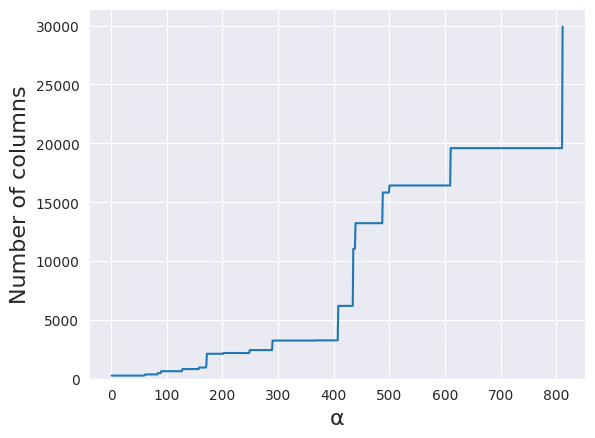

In [67]:
# 5. plot the longest subMSA vs alpha
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_style("darkgrid") #, {"grid.color": ".6"})

fig, ax = plt.subplots(1,1)
plot_longest_submsa=pd.DataFrame(info).plot(
    x="alpha",
    y="longest_submsa",
    ax=ax
    )

# plot_longest_submsa.text(x=0.5, y=1.1, s=f"Longest subMSA by {chr(945)} | {NAME}", fontsize=18, weight='bold', ha='center', va='bottom', transform=plot_longest_submsa.transAxes)
# plot_longest_submsa.text(x=0.5, y=1.05, s=f"asdad", fontsize=10, alpha=0.75, ha='center', va='bottom', transform=plot_longest_submsa.transAxes)

ax.set_xlabel(f"{chr(945)}", fontsize=16)
ax.set_ylabel("Number of columns", fontsize=16)

ax.set_ylim(bottom=0, top = 1.05*(ncols))
ax.legend().set_visible(False)

fig.savefig(PATH_SAVE.joinpath("longest_submsa_by_alpha"), dpi=300)

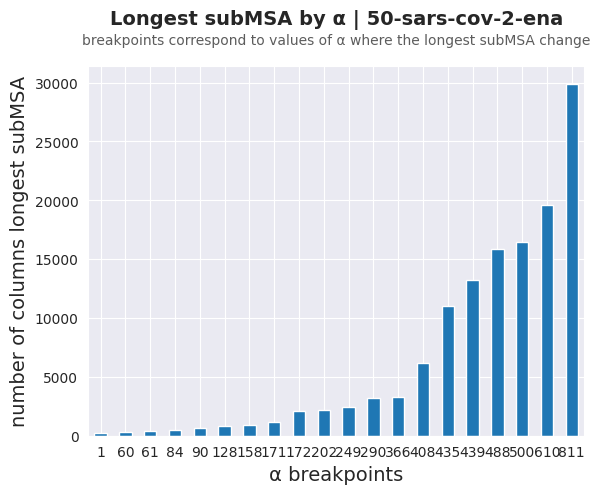

In [68]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1)
data_plot = pd.DataFrame(info).query(f"alpha in {alpha_breakpoints}")
# data_plot.fillna(1.0, inplace=True)

breakpoints_barplot = data_plot.plot(
    x="alpha",y="longest_submsa", kind="bar", 
    ax=ax
    )

breakpoints_barplot.text(x=0.5, y=1.1, s=f"Longest subMSA by {chr(945)} | {NAME}", fontsize=14, weight='bold', ha='center', va='bottom', transform=breakpoints_barplot.transAxes)
breakpoints_barplot.text(x=0.5, y=1.05, s=f"breakpoints correspond to values of {chr(945)} where the longest subMSA change", fontsize=10, alpha=0.75, ha='center', va='bottom', transform=breakpoints_barplot.transAxes)

ax.set_xlabel(f"{chr(945)} breakpoints", fontsize=14)
ax.set_ylabel("number of columns longest subMSA", fontsize=14)

ax.legend().set_visible(False)

# sns.move_legend(ax, "center left")

plt.xticks(rotation=0)
fig.savefig(PATH_SAVE.joinpath("barplot_longest_submsa_by_alpha_breakpoints"), dpi=300)

___

In [69]:
from src.plot.vertical_blocks import vertical_blocks as plot_vertical_blocks
import numpy as np 
import matplotlib.pyplot as plt


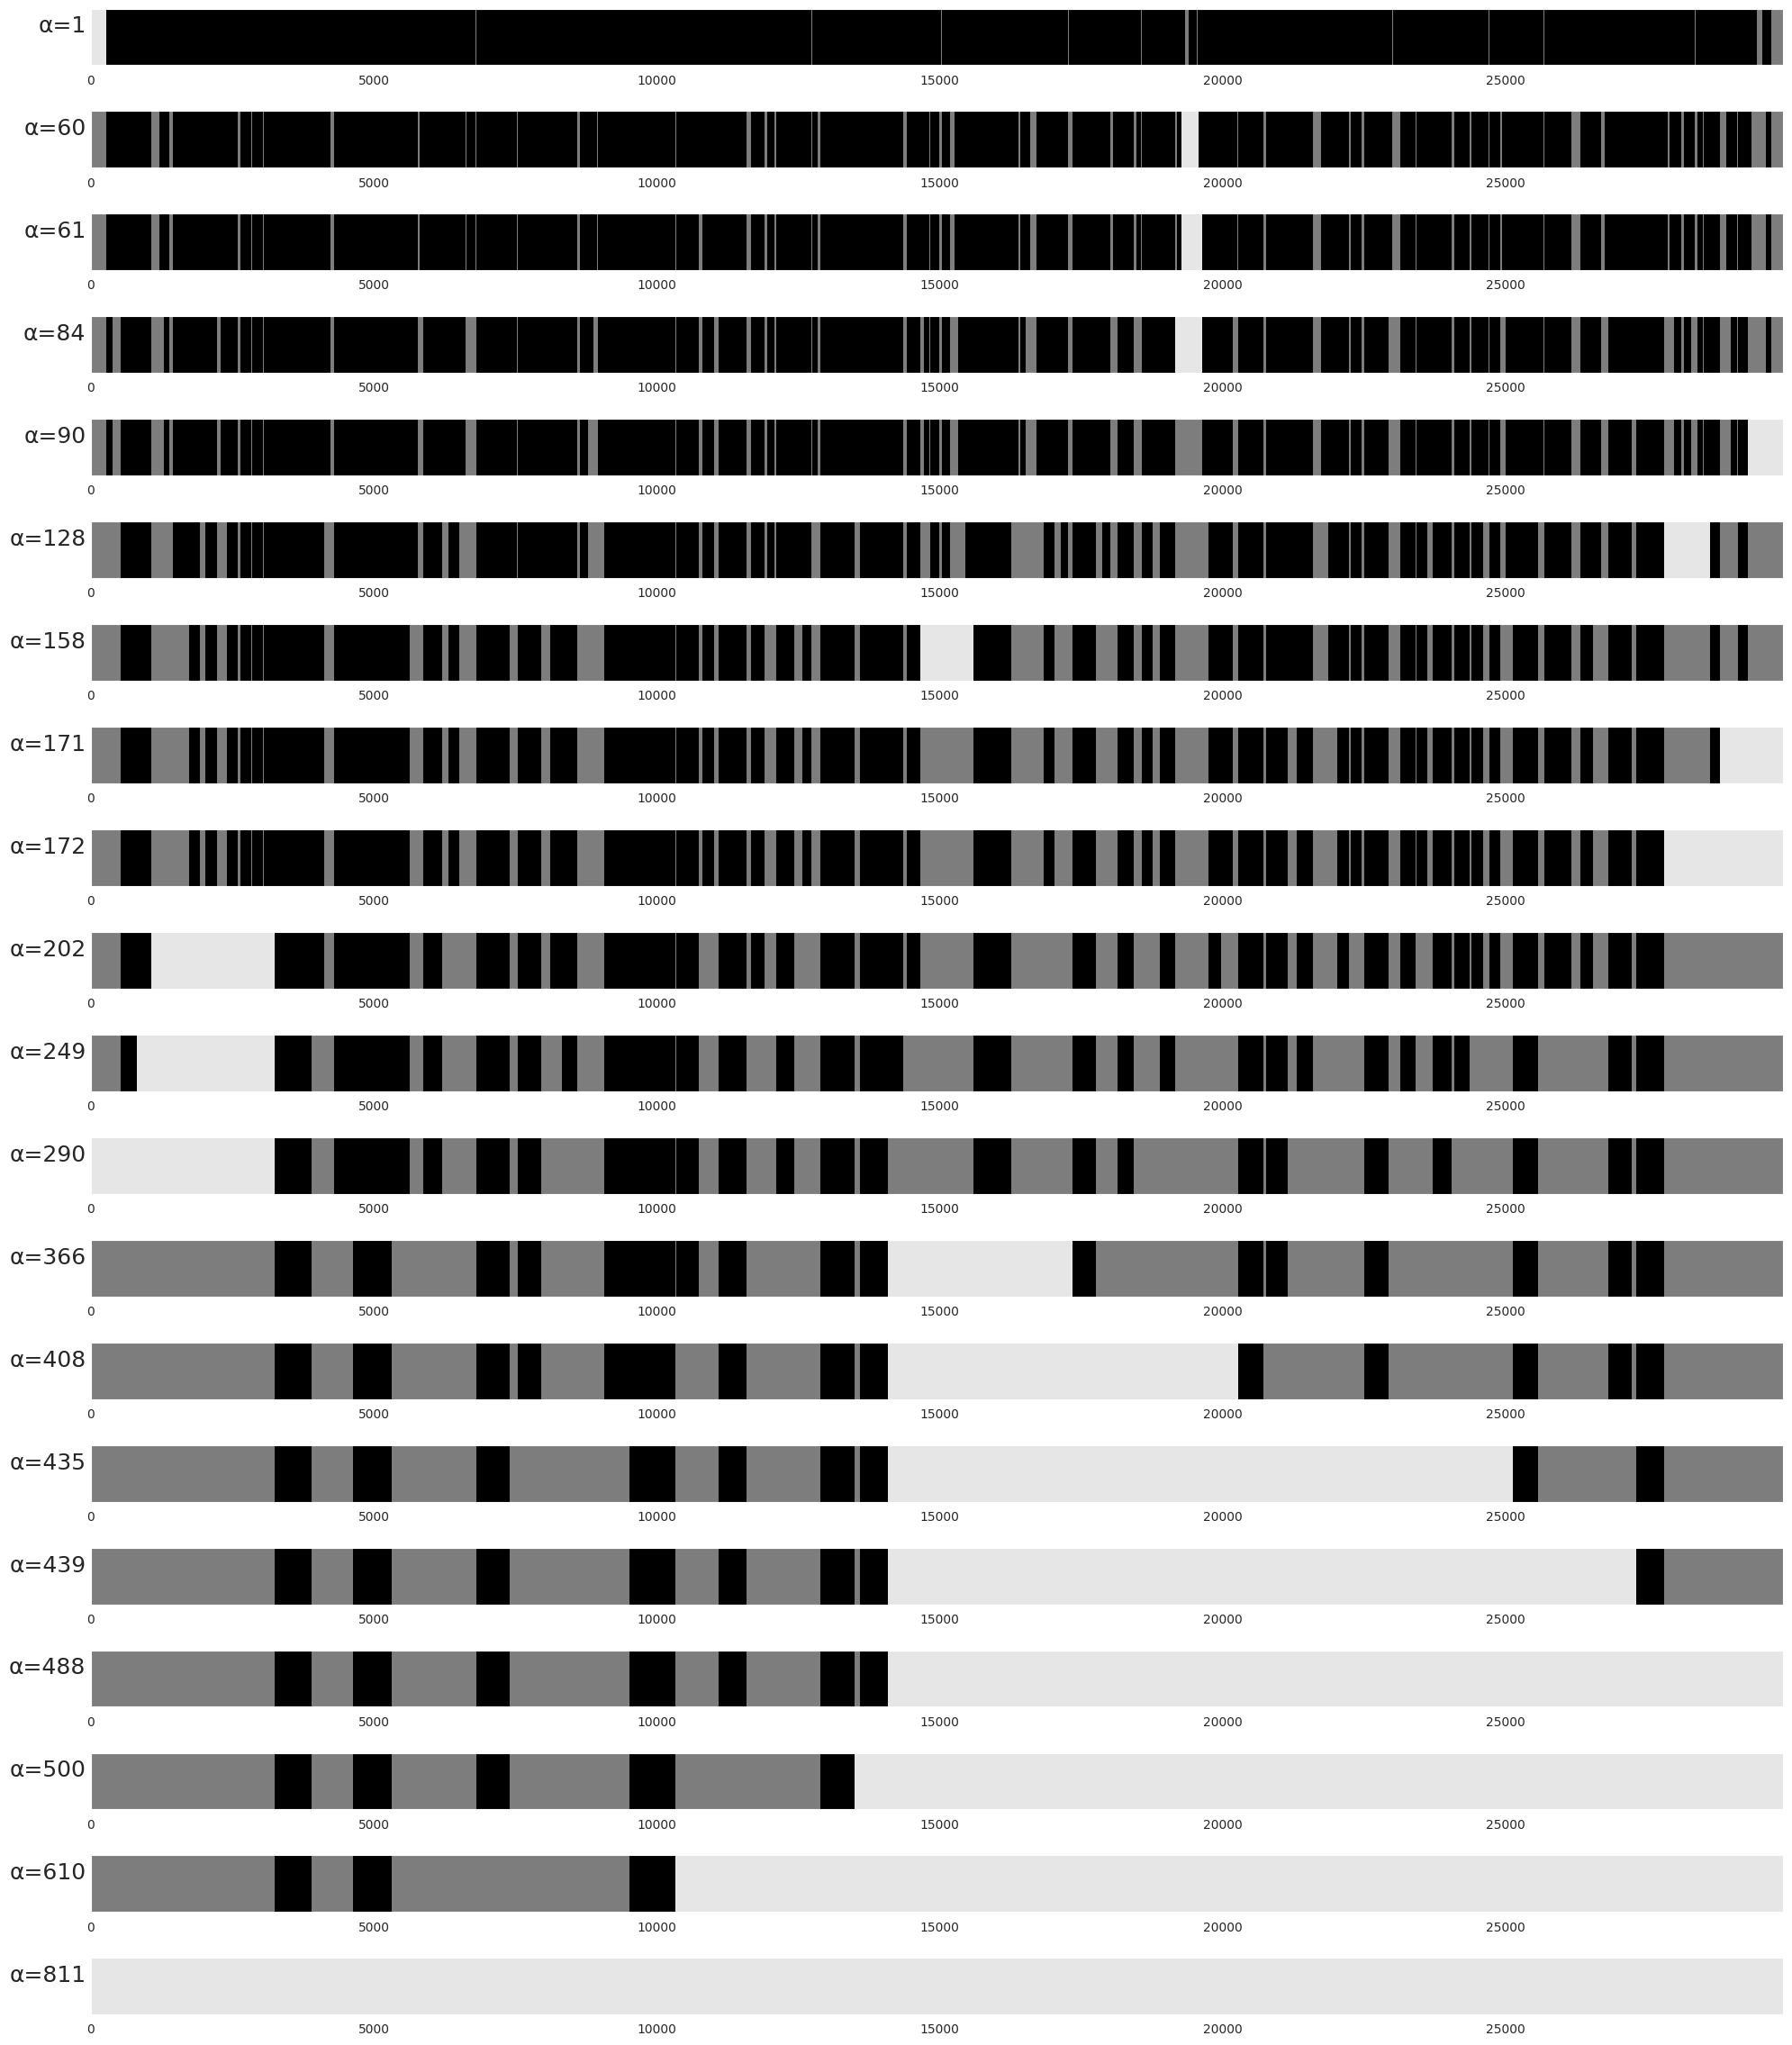

In [70]:
sns.set_style("dark")
nplots = len(alpha_breakpoints)

fig = plt.figure(1,(20,nplots+3))
fig.subplots_adjust(hspace=.4)

# alpha_breakpoints
blocks_longest_submsas_by_alpha = dict()
longest_submsa_by_alpha = dict()
number_of_submsas_by_alpha = dict()
for d in list(filter(lambda d: d["alpha"] in alpha_breakpoints, info)):
    longest_submsa_by_alpha[d["alpha"]] = d["longest_submsa"]
    blocks_longest_submsas_by_alpha[d["alpha"]] = d["blocks_longest_submsa"]
    number_of_submsas_by_alpha[d["alpha"]] = d["n_submsas"]
    

for j, alpha in enumerate(alpha_breakpoints):
    blocks_alpha = [b for b in vertical_blocks if b[2]-b[1]+1 >= alpha] 
    n_blocks_alpha = len(blocks_alpha)
    blocks_longest_submsa = blocks_longest_submsas_by_alpha[alpha]
    n_submsas = number_of_submsas_by_alpha[alpha]
    img = plot_vertical_blocks(blocks_alpha, blocks_optimum=blocks_longest_submsa, path_msa=path_msa, rowsfig=1000, return_pil=True)
    plt.subplot(nplots, 1, j+1)
    # plt.title(f"{chr(945)}={alpha} | largest subMSA ( {nrows} x {longest_submsa_by_alpha[alpha]} ) | Fixed Vertical Blocks = {n_blocks_alpha} | subMSAs = {n_submsas}")
    plt.yticks([])
    plt.ylabel(f"{chr(945)}={alpha}", fontdict={"fontsize":18}, rotation=0, ha="right")
    plt.imshow(np.asarray(img), cmap="gray", vmin=0, vmax=255, interpolation="none")

# plt.suptitle(f"""Vertical Blocks and subMSAs | SARS-CoV2 | MSA ({nrows},{ncols})""", y=1.5, fontsize=24, weight='bold', ha='center', va='bottom', transform=fig.axes[0].transAxes)
plt.tight_layout()

fig.savefig(PATH_SAVE.joinpath("vertical_blocks_by_alpha.png"),dpi=300)
# fig.savefig(PATH_SAVE.joinpath("vertical_blocks_by_alpha.pdf"),dpi=300)


In [71]:
nrows, ncols

(50, 29903)

___
#### Boxplot length of vertical blocks by alpha 

In [72]:
len_vb = [len(b[-1]) for b in vertical_blocks]

In [73]:
info_vb = []
for alpha in range(1,alpha_breakpoints[-1]+1):
    vb_alpha = [l for l in len_vb if l >=alpha] 
    for vb in vb_alpha:
        info_vb.append(
            {"alpha": alpha, "len_vb":vb}
        )

In [74]:
df_vb = pd.DataFrame(info_vb)

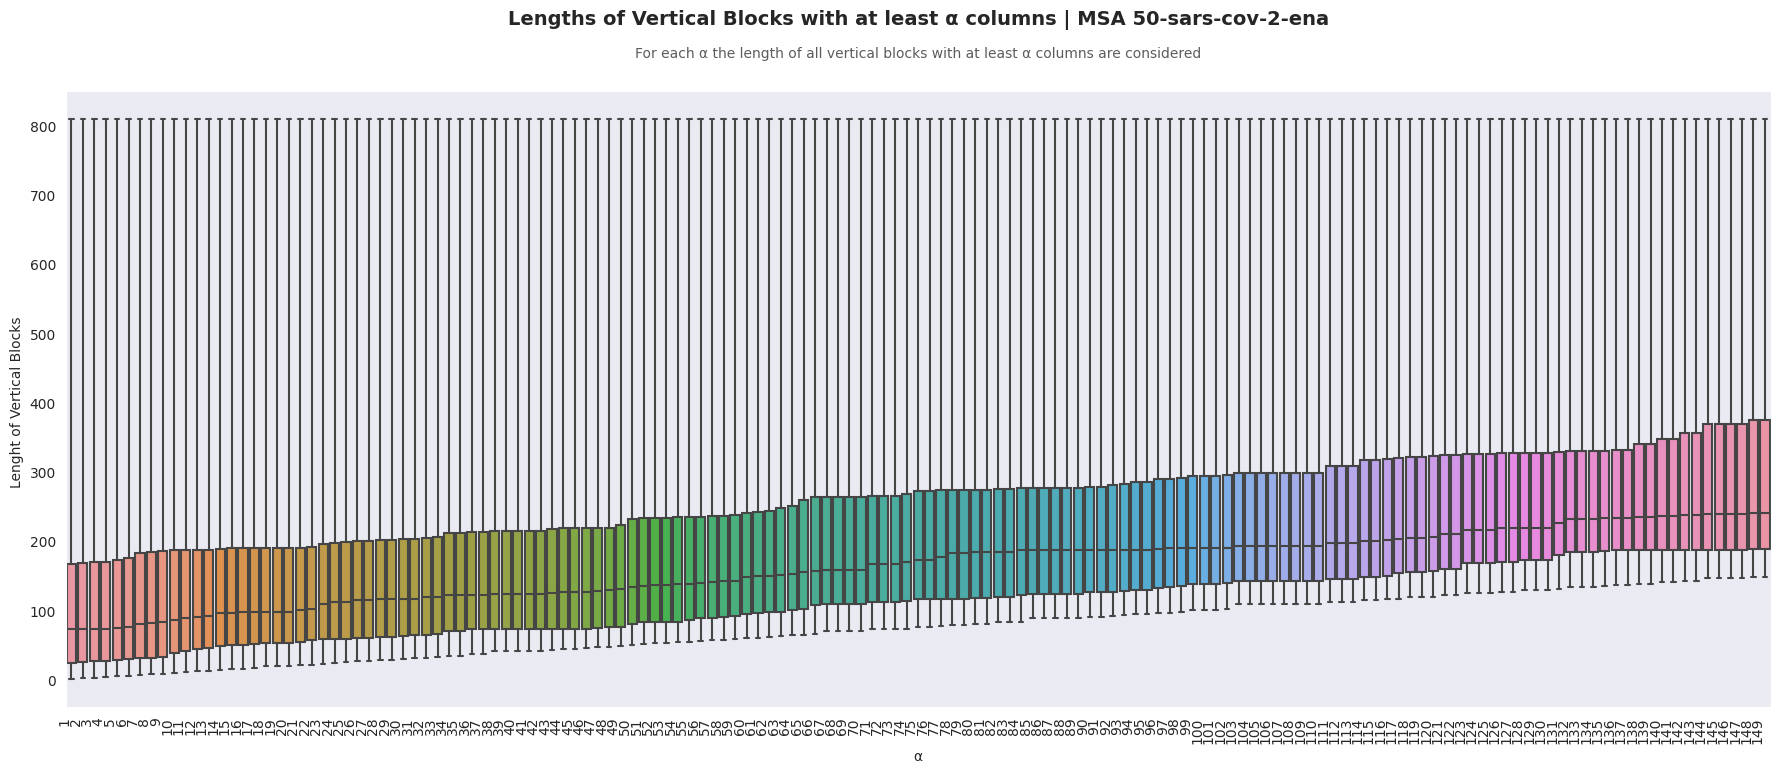

In [75]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(22)
fig.set_figheight(8)
sns.boxplot(data=df_vb.query("0 < alpha < 150"), x="alpha",y="len_vb", whis=(0, 100), ax=ax )#native_scale=True)
ax.set_xlabel(f"{chr(945)}")
ax.set_ylabel("Lenght of Vertical Blocks ")
ax.text(x=0.5, y=1.1, s=f"Lengths of Vertical Blocks with at least {chr(945)} columns | MSA {NAME}", fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"For each {chr(945)} the length of all vertical blocks with at least {chr(945)} columns are considered", fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

fig.savefig(PATH_SAVE.joinpath("boxplot_len_vertical_blocks_by_alpha.png"),dpi=300)

___
### Boxplot length of subMSAs by alpha

In [76]:
df_submsas = pd.DataFrame(info_submsas)

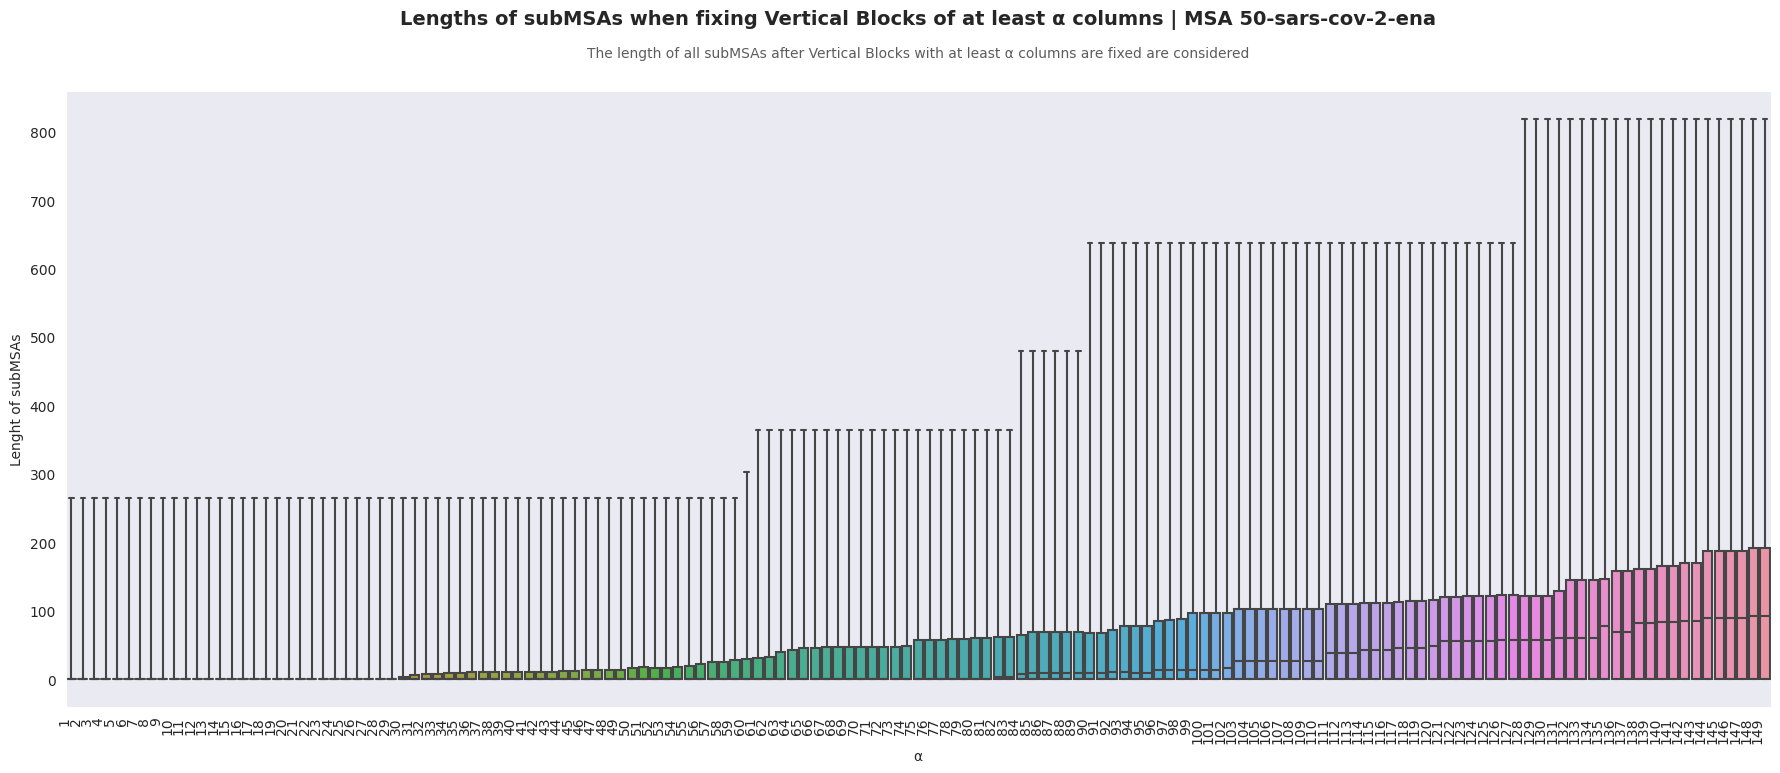

In [77]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(22)
fig.set_figheight(8)
sns.boxplot(data=df_submsas.query(" 0 < alpha < 150"), x="alpha",y="len_submsa", whis=(0, 100), ax=ax )#native_scale=True)
ax.set_xlabel(f"{chr(945)}")
ax.set_ylabel("Lenght of subMSAs")
ax.text(x=0.5, y=1.1, s=f"Lengths of subMSAs when fixing Vertical Blocks of at least {chr(945)} columns | MSA {NAME}", fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"The length of all subMSAs after Vertical Blocks with at least {chr(945)} columns are fixed are considered", fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

fig.savefig(PATH_SAVE.joinpath("boxplot_len_submsas_by_alpha.png"),dpi=300)